In [4]:
import pandas as pd
sample = pd.read_csv('/opt/ml/input/data/poc/KakaoTalk_Chat_IT개발자 구직:채용 정보교류방 (비번 2186)_2023-01-11-12-07-28.csv',engine='python', encoding = "utf8")
sample['Message2'] = pd.concat([pd.Series('None'),sample['Message'][:-1]]).reset_index(drop=True)

In [8]:
sample['Date'] = pd.to_datetime(sample['Date'],infer_datetime_format=True)

In [22]:
df_filtered2 = sample[ sample['Date'].isin(pd.date_range('2022-12-16', '2022-12-17',freq = 's'))]

In [19]:
df_filtered

,Date,User,Message,Message2
0,2022-12-16 11:09:22,roy,roy님이 들어왔습니다.\n운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에...,None
1,2022-12-16 11:09:22,방장봇,입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32n...,roy님이 들어왔습니다.\n운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에...
2,2022-12-16 12:39:38,꾸라,꾸라님이 들어왔습니다.,입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32n...
3,2022-12-16 12:39:38,방장봇,입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32n...,꾸라님이 들어왔습니다.
4,2022-12-16 13:01:59,라면먹는 백수,형님들 리액트 하다가 궁금한 거 하나만 여쭤보겟습니다 리액트에서 api 연동해야하는...,입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32n...
...,...,...,...,...
207,2022-12-16 22:38:22,건조한곰팡이,아하,스택오버플로우 나거나
208,2022-12-16 22:38:25,후론또국비맨,재귀콜수택초과도요,아하
209,2022-12-16 22:38:42,건조한곰팡이,감사합니다,재귀콜수택초과도요
210,2022-12-16 23:01:06,취준초보,취준초보님이 들어왔습니다.,감사합니다


In [24]:
df_filtered2.to_csv('/opt/ml/input/data/poc/2days.csv')

In [26]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('klue/roberta-large', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [27]:
emb1 = model.encode(df_filtered2['Message']) # R_i
emb2 = model.encode(df_filtered2['Message2']) #R_i+1

In [28]:
from sentence_transformers import util
cos_sim = util.cos_sim(emb1,emb2).diag()

In [29]:
import torch
std,mu = torch.std_mean(cos_sim)
T = mu-std

In [30]:
std,mu,T

(tensor(0.0694), tensor(0.8530), tensor(0.7835))

In [31]:
bin_seg = []
cnt = 0
for i in cos_sim:
    if i < T:
        bin_seg.append(1)
        cnt += 1
    else:
        bin_seg.append(0)
len(bin_seg)

321

In [32]:
cnt

43

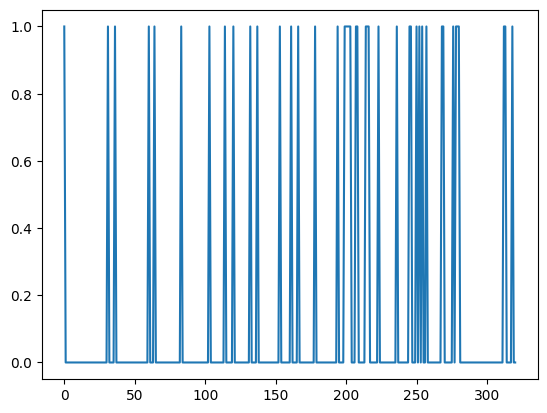

In [34]:
import matplotlib.pyplot as plt
plt.plot(bin_seg)

In [35]:
def depth_score_cal(scores):
	output_scores = []
	for i in range(len(scores)):
		lflag = scores[i]; rflag = scores[i];
		if i == 0:
			hl = scores[i]
			for r in range(i+1,len(scores)):
				if rflag <= scores[r]:
					rflag = scores[r]
				else:
					break
		elif i == len(scores):
			hr = scores[i]
			for l in range(i-1, -1, -1):
				if lflag <= scores[l]:
					lflag = scores[l]
				else:
					break
		else:
			for r in range(i+1,len(scores)):
				if rflag <= scores[r]:
					rflag = scores[r]
				else:
					break
			for l in range(i-1, -1, -1):
				if lflag <= scores[l]:
					lflag = scores[l]
				else:
					break
		depth_score = 0.5*(lflag+rflag-2*scores[i])
		output_scores.append(depth_score)

	return output_scores

In [41]:
d_scores = depth_score_cal(cos_sim)

In [69]:
import torch
d_scores = torch.tensor(d_scores)

In [70]:
std,mu = torch.std_mean(d_scores)
tau = mu + std
std,mu,tau

(tensor(0.0611), tensor(0.0420), tensor(0.1031))

In [71]:
d_scores = d_scores.cpu().numpy().tolist()

In [72]:
bin_seg2= []
cnt = 0
for i in d_scores:
    if i > tau:
        bin_seg2.append(1)
        cnt += 1
    else:
        bin_seg2.append(0)
cnt,len(bin_seg2)

(39, 321)

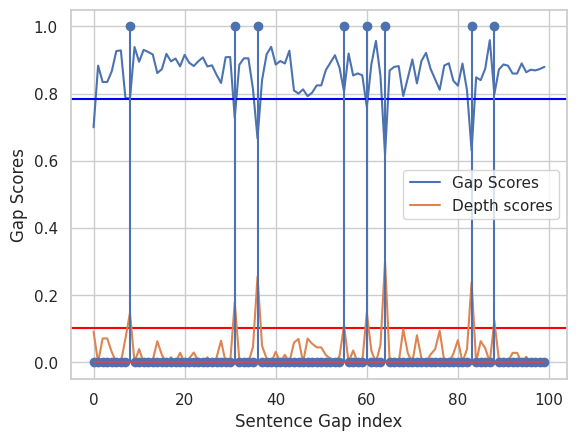

In [87]:
from matplotlib import pylab
# s, ss, d, b = tt.tokenize(input_text)
pylab.xlabel("Sentence Gap index")
pylab.ylabel("Gap Scores")
pylab.plot(range(len(cos_sim[:100])), cos_sim[:100], label="Gap Scores")
pylab.axhline(y=tau, color='red', linestyle='solid')
pylab.axhline(y=T, color='blue', linestyle='solid')
# pylab.plot(range(len(ss)), ss, label="Smoothed Gap scores")
pylab.plot(range(len(d_scores[:100])), d_scores[:100], label="Depth scores")
pylab.stem(range(len(bin_seg2[:100])), bin_seg2[:100])
pylab.legend()
pylab.show()
pylab.close()

유사도 기준의 정규 분포 : 유사도가 낮은 부분이 주제가 바뀐다.    
depth scores기준 정규분포 : 스코어가 높은 부분이 주제가 바뀐다.

In [86]:
for idx, val in enumerate(bin_seg2):
    if val == 1:
        print('-'*50,'seg_point_changed','-'*50)
    print(idx, '>>',df_filtered2['Message'][idx])

0 >> roy님이 들어왔습니다.
운영정책을 위반한 메시지로 신고 접수 시 카카오톡 이용에 제한이 있을 수 있습니다.
1 >> 입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U
2 >> 꾸라님이 들어왔습니다.
3 >> 입장 후 즉시 다음의 공지를 필독해주세요. 링크: https://bit.ly/32nBd2U
4 >> 형님들 리액트 하다가 궁금한 거 하나만 여쭤보겟습니다 리액트에서 api 연동해야하는데 로그인같은 api는 여러컴포넌트에서 써서 redux가 필요한듯한데 두 개의 컴포넌트에서 api(이 경우에는 글 crud 하는 api) 를 써야해서 이것도 redux를 쓸지 고민이 됩니다
5 >> 그냥 컴포넌트에서 호출해버릴까 vs redux 로 할까
6 >> api호출 위치는 하위 컴포넌트에 있어도 상관없는데 로그인한 상태 결과 저장은 최상위나 store에 있는게 맞을듯요
7 >> 아하 감사합니다~!
-------------------------------------------------- seg_point_changed --------------------------------------------------
8 >> 로그인정보는 redux를 쓰지않고 contextAPI로 구현하는거에 대해서 어떻게 생각하시나요
9 >> 솔직히 redux 어제 부터 공부했는데 너무 어려워서 그냥 contextAPI로 처리하고 싶은 마음이 큽니다 ㅎㅎ 근데 취업하려면 redux 알아야할 것같아서 조금 고민이 되요 
10 >> 리액트부분중에 제일 까다로운게 리덕스 아닌가요
11 >> 프론트 하실거면 리덕스 꼭 하시고
12 >> 백엔드인데 프론트 찍먹만 할거면 컨텍스트로 충분해여
13 >> 리덕스도 앵귤러 ngrx에 비하면 양반이더군요 ㄷㄷ
14 >> 해보시는걸 추천해요
15 >> 상태관리 라이브러리 ㅈㄴ 많아서 내가 리덕스를 배워도 회사에서는 안쓸 수 있거든요
16 >> 그래도 전역 상태관리 작동방식의 보편적인건 redux랑 redux-too

In [83]:
bin_seg

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


In [15]:
def MarginRankingLoss(p_scores, n_scores):
    margin = 1
    scores = margin - p_scores + n_scores
    scores = scores.clamp(min=0)

    return scores.mean()

In [1]:
import nltk
from nltk.tokenize import TextTilingTokenizer

In [2]:
from sentence_transformers import SentenceTransformer, models

class KorTextTilingTokenizer(TextTilingTokenizer):
    def __init__(
        self,
        w=20,
        k=10,
        similarity_method=0,
        stopwords=None,
        smoothing_method=[0],
        smoothing_width=2,
        smoothing_rounds=1,
        cutoff_policy=1,
        demo_mode=False,
    ): ## 바꾼 부분
        super().__init__()
        word_embedding_model = models.Transformer('klue/roberta-large', max_seq_length=256)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

        self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        if stopwords is None:
            stopwords = [] #🦊 stopword 사용하지 않음 ## 바꾼 부분 good
        self.__dict__.update(locals())
        del self.__dict__["self"]

    def tokenize(self, text): 
        """Return a tokenized copy of *text*, where each "token" represents
        a separate topic."""

        lowercase_text = text.lower()

        # STEP 0. 인풋이 구조적으로 문단을 나누는 경우 분리점을 찾음 ("[ \t\r\f\v]*\n[ \t\r\f\v]*\n[ \t\r\f\v]*" 등)
        paragraph_breaks = self._mark_paragraph_breaks(text)
        text_length = len(lowercase_text)

        # STEP 1. 토크나이징 진행

        # 1-1) 글자를 제외한 문장부호 등을 제거함 ## 바꾼 부분
        nopunct_text = "".join(  c for c in lowercase_text if re.match(r"[ㄱ-힣0-9a-z\-' \n\t]", c) ) #🦊

        nopunct_par_breaks = self._mark_paragraph_breaks(nopunct_text)

        # 1-2) 토큰 시퀀스로 나누기 => "문장"의 단위가 됨
        tokseqs = self._divide_to_tokensequences(nopunct_text)

        # # Filter stopwords => 한국어에서는 적용되지 않음
        for ts in tokseqs:
            ts.wrdindex_list = [
                wi for wi in ts.wrdindex_list if wi[0] not in self.stopwords
            ]

        # STEP 3. 문단 / 문장 별로 단어의 등장 횟수를 체크해 표를 만들기
        token_table = self._create_token_table(tokseqs, nopunct_par_breaks)
        # End of the Tokenization step
        
        # # Lexical score determination
        if self.similarity_method == 0:
            gap_scores = self._block_comparison(tokseqs, token_table)
        elif self.similarity_method == 1:
            raise NotImplementedError("Vocabulary introduction not implemented")
        else:
            raise ValueError(
                f"Similarity method {self.similarity_method} not recognized"
            )
        emb = self.model.encode(tokseqs)


        if self.smoothing_method == [0]:
            smooth_scores = self._smooth_scores(gap_scores)
        else:
            raise ValueError(f"Smoothing method {self.smoothing_method} not recognized")
        # End of Lexical score Determination

        # Boundary identification
        depth_scores = self._depth_scores(smooth_scores)
        segment_boundaries = self._identify_boundaries(depth_scores)

        normalized_boundaries = self._normalize_boundaries(
            text, segment_boundaries, paragraph_breaks
        )
        # End of Boundary Identification
        segmented_text = []
        prevb = 0

        for b in normalized_boundaries:
            if b == 0:
                continue
            segmented_text.append(text[prevb:b])
            prevb = b

        if prevb < text_length:  # append any text that may be remaining
            segmented_text.append(text[prevb:])

        if not segmented_text:
            segmented_text = [text]

        if self.demo_mode:
            return gap_scores, smooth_scores, depth_scores, segment_boundaries
        return segmented_text

In [36]:
ttt.tokenize(''.join(lsa))

ValueError: No paragraph breaks were found(text too short perhaps?)

In [34]:
''.join(lsa).lower()

' 사진 내채공 기준이 바뀐거같네요 조건이 더 너프되었네요 it는 이제 아예 내채공이 안되는군요 흠비옷입은 튜브님이 들어왔습니다.비옷입은 튜브님이 나갔습니다. 50인미만.. 내채공 망했네요 헐 내채공 끝났네 흠냐.. tip 교내기업 정도면 되겠네요 퇴근하고 집가는데 많이피곤하군요 내채공 멸망... 이거어차피 연봉 3500미만이라 옛날에비해서 받기힘들어져서 ㅠ 작년도 못받는분들 많았을거에요 작년이래 올해'